###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1268470`


In [2]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score

this function log_gaussian returns the log of the likelihood, $$ \Large\log(P(x_i | c_j)) = \log(\frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-(x_i-\mu)^2}{2\sigma^2}}) = -\log(\sigma)-\frac{1}{2}\log(2)-\frac{1}{2}\log(\pi)-\frac{(x_i-\mu)^2}{2\sigma^2}$$

In [3]:
def log_gaussian(param, x):
    mu = param['mu']
    sd = param['sd']
    return -np.log(sd)-1/2*np.log(2)-1/2*np.log(np.pi)-(x - mu)**2 / 2 / sd**2

In [4]:
# This function prepares the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(file_name):
    file = pd.read_csv(file_name+'.csv', sep=',')
    return file.iloc[:, 1:-1], file['label']

In [5]:
# This function calculates prior probabilities from the training data

def calc_prior(labels):
    prior_prob = {}
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    n = len(labels)
    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (label_counts[i] / n)
    return prior_prob  # dictionary: keys the label & value the corresponding prior probability

In [6]:
# this function calculates the likelihood from the training data

def calc_likelihoods(data, labels):
    unique_labels = np.unique(labels) # set of labels
    features_list = data.columns # the name of the features, ensuring to exclude label*
    likelihood = {}
    
    for feature in features_list:
        likelihood[feature] = {}
        for label in unique_labels:
            values = data.loc[labels==label, feature]
            likelihood[feature][label] = {'mu': np.mean(values), 'sd': np.std(values, ddof=1)}
            # find all values for a certain feature with class == label, then record the mean and standard deviation

    return likelihood  # dictionary: first key is the feature, second key the label then the corresponding value
                       # is the parameters of the normal distribution (mean & standard deviation)

In [7]:
# Builds the Naive Bayes model based on the training data, using the calc_likelihoods and calc_prior functions

def train(data, labels):
    return calc_prior(labels), calc_likelihoods(data, labels)

In [8]:
# This function, given the trained Naive Bayes classifier, returns the (relative) posterior probabilities for each instance
# Note the _task1 highlights this version of the calc_posterior is only for Task 1 and there is a _task2 edition
# of calc_posterior for Task 2 where the focus is on handling missing values
def calc_posterior_task1(data, prior_prob, likelihood):
    posterior_probs = []
    for _, instance in data.iterrows(): # go through each instance
        post_probs = {}
        for label in prior_prob: # consider each label for each instance and calculate the posterior probability
            # takes the log of the pdf of the normal distribution with the calculated parameters with the instance's feature value
            # the implementation allows us to sum up the probabilities, avoiding underflow issues due to multiplying very low values
            post_probs[label] = np.log(prior_prob[label])
            for feature in likelihood:
                    post_probs[label] += log_gaussian(likelihood[feature][label], instance[feature])
        posterior_probs.append(post_probs)

    return posterior_probs  # list of dictionaries, where each dictionary has key, value pairs being the
                            # class label and the corresponding relative posterior probability

In [9]:
# This function predicts classes for new items in a test dataset

def predict(data, prior_prob, likelihood, calc_posterior_f=calc_posterior_task1):
    # Calculate posterior probabilities, *uses the given posterior function for easier implementation with Task 2: missing values
    posterior_probs = calc_posterior_f(data, prior_prob, likelihood)
    # Return the argmax for each instance
    return [max(probs, key=probs.get) for probs in posterior_probs]

In [21]:
# This function evaluates the prediction performance by comparing the model’s class outputs to ground
# truth labels

def evaluate(predictions, true):
    pos, neg = 'classical', 'pop'  # as defined in the question, these are the positive and negative class labels
    labels_l = [pos, neg]
    conf_matrix = confusion_matrix(true, predictions, labels=labels_l)  # produce the confusion matrix using sklearn
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_l)  # format the confusion matrix as a graphic
    disp.plot(colorbar=False, cmap='binary')
    plt.title('Naive Bayes Pop vs. Classical Music Classifier Confusion Matrix')
    plt.savefig('ConfusionMatrix')  # save a copy
    plt.show()  # formatting the confusion matrix graphic is complete, so show it
    bin_predictions = np.array(predictions) == pos   # converts the list of class labels to an easier format to derive the
    bin_true = np.array(true) == pos                 # performance in terms of accuracy, precision and recall (using sklearn)
    return accuracy_score(true, predictions), precision_score(bin_true, bin_predictions), recall_score(bin_true, bin_predictions)

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [35]:
# the training dataset & class labels
data_train, labels_train = preprocess('pop_vs_classical_train')
# train the model
prior_prob, likelihood = train(data_train, labels_train)

# the testing dataset & class labels
data_test, labels_test = preprocess('pop_vs_classical_test')
# generate the predicted class labels for the testing dataset
predictions = predict(data_test, prior_prob, likelihood, calc_posterior_task1)

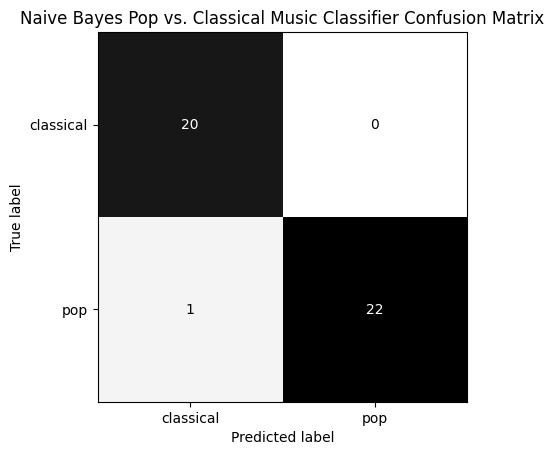

Naive Bayes Pop Vs. Classical Music Classifier performed with an accuracy of 0.977, precision of 0.952 and recall of 1.0, noting that the classical music genre was treated as the 'positive' class.


In [36]:
# evaluate the accuracy, precision and recall of the Naive Bayes pop vs classical classifier
print("Naive Bayes Pop Vs. Classical Music Classifier performed with an accuracy of {}, precision of {} and recall of {}, noting that the classical music genre was treated as the 'positive' class.".format(*[round(x,3) for x in evaluate(predictions, labels_test)]))

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

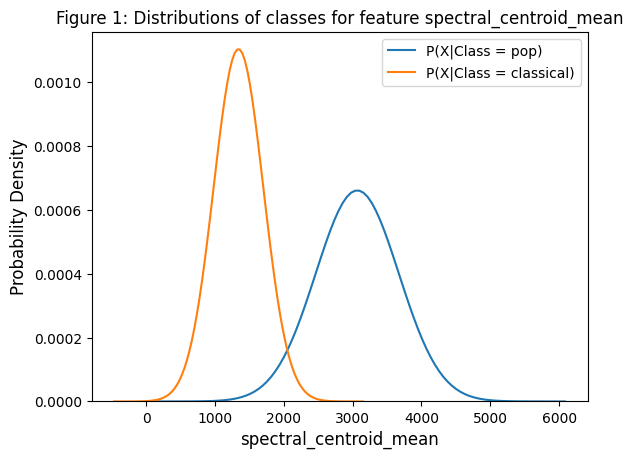

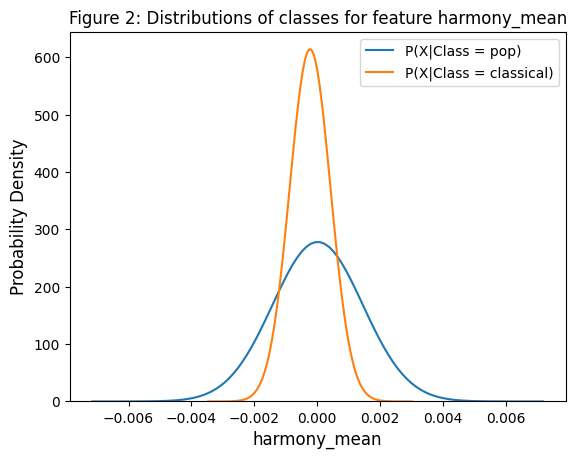

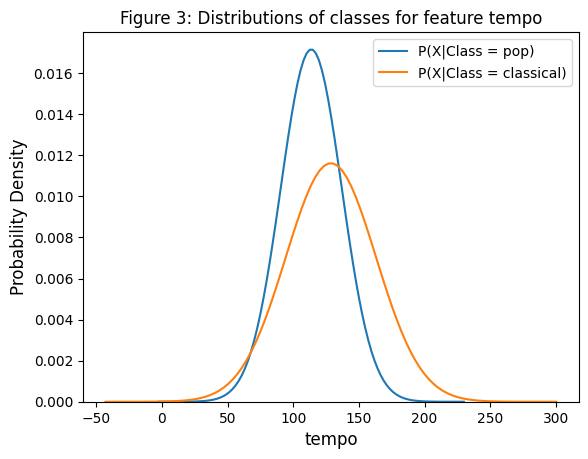

In [38]:
# We have just trained our dataset in Task 1, so the implementation uses that likelihood variable still in memory
    # otherwise please run the first cell from Q1 to train the Naive Bayes pop vs classical classifier before this
features = ['spectral_centroid_mean', 'harmony_mean', 'tempo']  # features to go over
labels = ['pop', 'classical']  # labels to go over
for feature in features:
    for lab in labels:
        mu, sd = likelihood[feature][lab]['mu'], likelihood[feature][lab]['sd']  # the parameters of the normal distribution
        x = np.linspace(mu - 5*sd, mu + 5*sd, 100)  # the x-axis values to use
        plt.plot(x, norm.pdf(x, mu, sd))  # produces the plot, using norm.pdf from scipy.stats
    # now just format the graphics for aesthetics and the relevant details
    plt.title("Figure {}: Distributions of classes for feature {}".format(features.index(feature)+1,feature))
    plt.legend(["P(X|Class = {})".format(lab) for lab in labels])
    ylim = plt.gca().get_ylim()
    plt.ylim([0, ylim[1]])
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.savefig('Fig{}'.format(features.index(feature)+1))  # save a copy
    plt.show()

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q6 - Recall I am working by myself so choosing one of the questions in Task 2, I choose Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [17]:
# a function that evaluates the classifier using One-vs-Rest

def eval_multimodel(labels_test, predictions, accuracy_df, recall_df, precision_df, perc):
    unique_labels = list(set(predictions).union(set(labels_test)))  # issue where, when the accuracy is too low, the classifier may classify
                                                    # an instance as some label seen in the training set but not in the testing labels dataset
    for label in unique_labels:
        bin_true = np.array(labels_test) == label  # One-vs-Rest focusing on the current label in the for loop
        bin_predict = np.array(predictions) == label
        accuracy_df.loc[perc, label] = accuracy_score(bin_true, bin_predict) # records the performance evaluators in dataframes
        recall_df.loc[perc, label] = recall_score(bin_true, bin_predict)
        precision_df.loc[perc, label] = precision_score(bin_true, bin_predict)
    accuracy_df.loc[perc, 'overall'] = accuracy_score(labels_test, predictions)

In [18]:
# Task 2 edition of calc_posterior, where now if the value of the instance's feature is not NA, then add it in & otherwise skip

def calc_posterior_task2(data, prior_prob, likelihood):
    posterior_probs = []
    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = np.log(prior_prob[label])
        for feature in likelihood:
            if not pd.isna(instance.loc[feature]):
                for label in prior_prob:
                    post_probs[label] += log_gaussian(likelihood[feature][label], instance[feature])
        posterior_probs.append(post_probs)

    return posterior_probs

In [25]:
# this function is for experimenting with different percentages of missing data in gztan_test
# should a testing file at that deletion percent and index i already exist, saves us from having to create one

def create_deleted_csv(deletion_percent, file_name, i):
    if os.path.exists('./{}/{}/test{}.csv'.format(file_name, deletion_percent, i)):
        return preprocess('./{}/{}/test{}'.format(file_name, deletion_percent, i))
    file = pd.read_csv(file_name+'.csv', sep=',')  # read the original (no missing data) file
    start_col = 1  # recall column 0 is the filename, so not going to delete data there
    end_col = len(file.columns) - 2  # also would not want to delete the class label
    numRows = file.shape[0]  # number of rows
    to_delete = round((numRows*end_col*deletion_percent)/100)  # calculates, rounded to nearest integer, the number of cells to delete
    if deletion_percent > 55:  # if we are to delete more than 50%: perhaps quicker considering the % to keep, though must copy labels column
        to_keep = numRows*end_col - to_delete
        df = pd.DataFrame(data = file['label'], index=range(numRows),columns=file.columns)
        rand_list = list(np.random.randint(low=[0,start_col],high=[numRows, end_col],size=[to_keep, 2]))   # generates a random list of size to_keep
        while rand_list:
            new = rand_list.pop(0)
            if not pd.isna(df.iloc[new[0], new[1]]):
               rand_list.append(np.random.randint(low=[0,start_col],high=[numRows, end_col]))
            else:
                df.iloc[new[0], new[1]] = file.iloc[new[0], new[1]]  # since our new dataframe has a NA there, add in the info
        file = df
    else:
        rand_list = list(np.random.randint(low=[0,start_col],high=[numRows, end_col],size=[to_delete, 2]))
        while rand_list:
            new = rand_list.pop(0)
            if pd.isna(file.iloc[new[0], new[1]]): # if the newly popped random cell has already been deleted,
                                                   # to achieve the deletion_percent %: add another random cell and the cycle repeats
               rand_list.append(np.random.randint(low=[0,start_col],high=[numRows, end_col]))
            else:
                file.iloc[new[0], new[1]] = pd.NA  # deleletion
    os.makedirs('./{}/{}'.format(file_name, deletion_percent), exist_ok=True) # make sure the file directory exists
    file.to_csv('./{}/{}/test{}.csv'.format(file_name, deletion_percent, i), index = False)  # save a copy of the file
    return file.iloc[:, 1:-1], file['label']  # returns the data, labels in the same format as preprocess function

Loading... 2%
 Loading... 4%
Loading... 6%
 Loading... 8%
Loading... 10%
 Loading... 12%
Loading... 14%
 Loading... 16%
Loading... 18%
 Loading... 20%
Loading... 22%
 Loading... 24%
Loading... 26%
 Loading... 28%
Loading... 30%
 Loading... 32%
Loading... 34%
 Loading... 36%
Loading... 38%
 Loading... 40%
Loading... 42%
 Loading... 44%
Loading... 46%
 Loading... 48%
Loading... 50%
 Loading... 52%
Loading... 54%
 Loading... 56%
Loading... 58%
 Loading... 60%
Loading... 62%
 Loading... 64%
Loading... 66%
 Loading... 68%
Loading... 70%
 Loading... 72%
Loading... 74%
 Loading... 76%
Loading... 78%
 Loading... 80%
Loading... 82%
 Loading... 84%
Loading... 86%
 Loading... 88%
Loading... 90%
 Loading... 92%
Loading... 94%
 Loading... 96%
Loading... 98%


D:\University\2023\Semester 1\Machine Learning\Machine-Learning-Project-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\University\2023\Semester 1\Machine Learning\Machine-Learning-Project-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\University\2023\Semester 1\Machine Learning\Machine-Learning-Project-1\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

 Loading... 100%


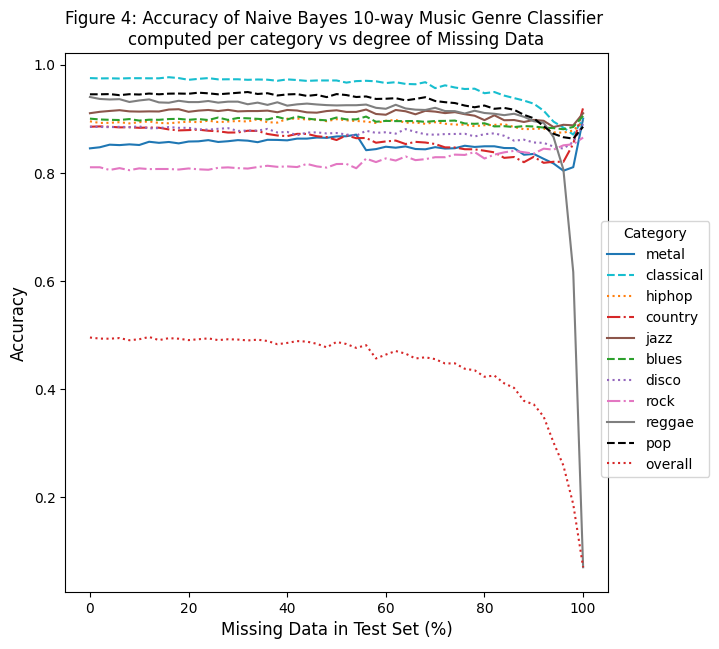

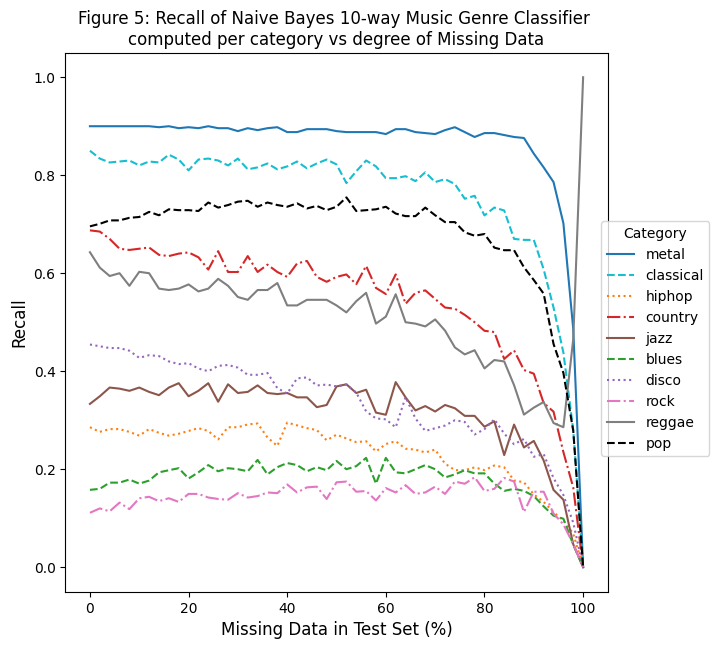

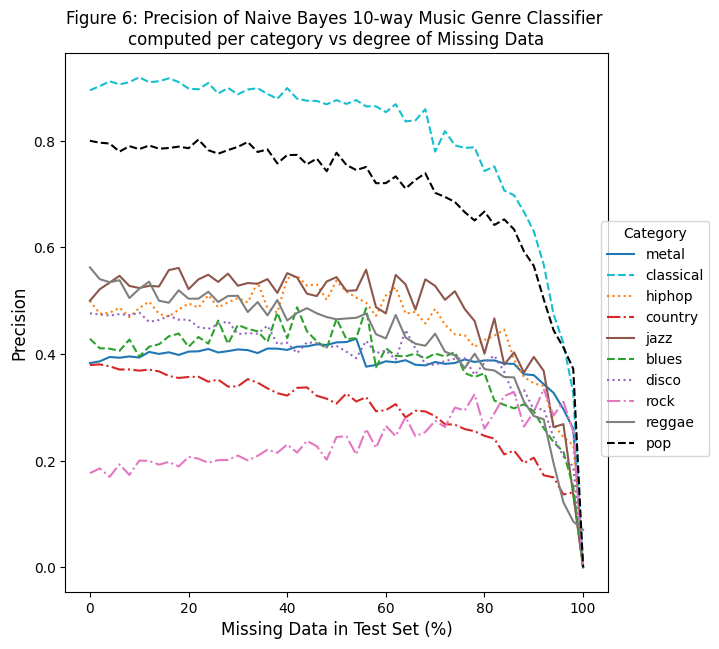

In [27]:
increment_size = 10  # size of deletion percentage increments; lower it is the longer this will take
del_percent_list = range(increment_size, 101, increment_size)
n_runs = 3  # number of runs at each deletion percentage
            # just a note to the markers: for more accurate experimental results, I ran with increment_size = 2 and n_runs = 25
            # however this took 10 minutes, so since the assignment warns the code has to be reproducible try
            # ~ running with increment_size = 10 and n_runs = 3 only takes 16 seconds
data_train, labels_train = preprocess('gztan_train')
prior_prob, likelihood = train(data_train, labels_train)

data_test, labels_test = preprocess('gztan_test')
predictions = predict(data_test, prior_prob, likelihood, calc_posterior_task1)  # no missing data so such checks are unnecessary

plots = ['Accuracy', 'Recall', 'Precision']
accuracy_df = pd.DataFrame()  # dataframes to record the performance
recall_df = pd.DataFrame()
precision_df = pd.DataFrame()
classes = np.unique(labels_train)

eval_multimodel(labels_test, predictions, accuracy_df, recall_df, precision_df, 0)  # record performance without any data deleted

for j, percent in enumerate(del_percent_list): # produce the datasets with the deletion levels and record their performance
    y_predicted = []  # arrays to hold the predicted labels across all the n_runs
    y_true = []
    for i in range(n_runs): # goes over n_runs different versions, due to randomisation, of the dataset at that deletion level
        data_test, labels_test = create_deleted_csv(percent, 'gztan_test', i)
        y_true += list(labels_test)
        y_predicted += predict(data_test, prior_prob, likelihood, calc_posterior_task2)
    # evaluates the combined list of predictions against the combined list of true labels
    eval_multimodel(y_true, y_predicted, accuracy_df, recall_df, precision_df, percent)
    print(" "*(j%2)+"Loading... {}%".format(percent))  # feel free to comment out, but left it on as it is
                                                       # helpful to know the progress of the experiment
# the colours and linestyles for the plot
colors = ['C0', 'C9', 'C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'C7', 'k', 'C3']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
for i, df in enumerate([accuracy_df, recall_df, precision_df]):  # generate each plot for the different evaluation metrics
    fig, ax = plt.subplots()
    for j, col in enumerate(df.columns):
        df[col].plot(figsize=(7, 7), linestyle=linestyles[j % 4], color=colors[j])  # plot each category with a different linestyle & colour
    plt.ylabel(plots[i], fontsize=12)
    plt.title("Figure {}: {} of Naive Bayes 10-way Music Genre Classifier \ncomputed per category vs degree of Missing Data".format(i+4, plots[i]))
    plt.xlabel('Missing Data in Test Set (%)', fontsize=12)
    plt.legend(title="Category", loc='upper right', bbox_to_anchor=(1.2, 0.7))
    plt.savefig('./gztan_test/{}_I-{}N-{}'.format(plots[i], increment_size, n_runs))  # save a copy
    plt.show()
    df.to_csv("./gztan_test/{}_I-{}N-{}.csv".format(plots[i], increment_size, n_runs))  # stores the performance stats

In [42]:
# for calculating the prior probabilities in gztan_test, assisting the analysis of why the classifier
# behaves in the way it does with respect to the missing data %
data_test, labels_test = preprocess('gztan_test')
prior_prob_test = {}
unique_labels, label_counts = np.unique(labels_test, return_counts=True)
n = len(labels_test)
for i in range(len(unique_labels)):
    prior_prob_test[unique_labels[i]] = (label_counts[i] / n)
pd.DataFrame(data = prior_prob_test, index=["Proportion"]).to_csv("gztan_test_proportions.csv")